In [117]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert
from antropy import sample_entropy
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import glob
from collections import Counter
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits


In [118]:
device = torch.device("cuda")

In [119]:
data = load_digits()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [120]:
def balance_classes(X, y):
    valid_mask = y != 'Missing'
    X = X[valid_mask]
    y = y[valid_mask]
    unique_classes = np.unique(y)
    min_class_count = min(Counter(y).values()) 
    print(min_class_count)
    X_balanced = []
    y_balanced = []

    for cls in unique_classes:

        X_cls = X[y == cls]
        y_cls = y[y == cls]

        X_down, y_down = resample(X_cls, y_cls, 
                                  replace=False,
                                  n_samples=min_class_count,
                                  random_state=42)

        X_balanced.append(X_down)
        y_balanced.append(y_down)

    X_final = np.vstack(X_balanced)
    y_final = np.concatenate(y_balanced)

    return X_final, y_final 

In [121]:
dataset = TensorDataset(X, y)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
val_ds

In [122]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.out = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        return self.out(x)

In [123]:
input_size = X.shape[1]
num_classes = len(np.unique(y))
model = SimpleNet(input_size, num_classes)
model.to(device)


SimpleNet(
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)

In [124]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)



In [125]:
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(100):
    model.train()
    tr_tacni = 0
    tr_ukupno = 0
    epoch_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        #print(predicted, batch_y)
        tr_tacni += (predicted == batch_y).sum().item()
        tr_ukupno += batch_y.size(0)

    train_acc = tr_tacni / tr_ukupno
    avg_loss = epoch_loss / len(train_loader)

    model.eval()
    val_tacni = 0
    val_ukupno = 0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            _, val_pred = torch.max(val_outputs, dim=1)
            val_tacni += (val_pred == val_y).sum().item()
            val_ukupno += val_y.size(0)

    val_acc = val_tacni / val_ukupno

    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%, Learning Rate: {current_lr:.6f}")

Epoch 1, Loss: 2.1043, Train Acc: 27.76%, Val Acc: 42.75%, Learning Rate: 0.001000
Epoch 2, Loss: 0.8675, Train Acc: 68.02%, Val Acc: 81.78%, Learning Rate: 0.001000
Epoch 3, Loss: 0.3801, Train Acc: 86.00%, Val Acc: 89.59%, Learning Rate: 0.001000
Epoch 4, Loss: 0.1962, Train Acc: 93.00%, Val Acc: 89.96%, Learning Rate: 0.001000
Epoch 5, Loss: 0.1431, Train Acc: 94.59%, Val Acc: 94.80%, Learning Rate: 0.001000
Epoch 6, Loss: 0.0988, Train Acc: 96.18%, Val Acc: 94.05%, Learning Rate: 0.001000
Epoch 7, Loss: 0.0683, Train Acc: 98.01%, Val Acc: 94.42%, Learning Rate: 0.001000
Epoch 8, Loss: 0.0365, Train Acc: 99.20%, Val Acc: 93.31%, Learning Rate: 0.001000
Epoch 9, Loss: 0.0495, Train Acc: 98.41%, Val Acc: 96.28%, Learning Rate: 0.001000
Epoch 10, Loss: 0.0185, Train Acc: 99.60%, Val Acc: 96.65%, Learning Rate: 0.001000
Epoch 11, Loss: 0.0145, Train Acc: 99.60%, Val Acc: 96.28%, Learning Rate: 0.001000
Epoch 12, Loss: 0.0046, Train Acc: 100.00%, Val Acc: 96.65%, Learning Rate: 0.001000


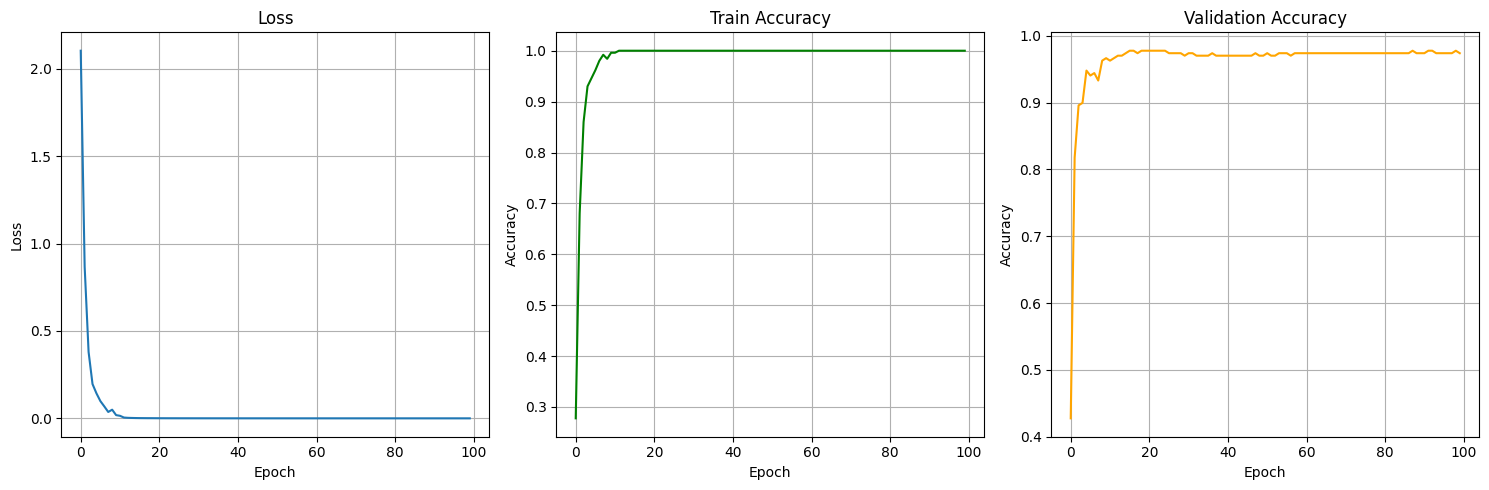

In [126]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()

plt.tight_layout()
plt.show()